In [32]:
# import modules
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import osmnx as ox
import pandas as pd
import networkx as nx
from shapely.geometry import LineString
from tabulate import tabulate
import math as math
from geojson import Feature, LineString, FeatureCollection
import random
import statistics
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np




In [33]:
# Reading csv files into panda DataFrames
dfNodes = pd.read_csv("/Users/suvihanninen/Desktop/Research_project/CoolWalk/data_Nottingham/nottingham_nodes.csv")
dfEdges = pd.read_csv("/Users/suvihanninen/Desktop/Research_project/CoolWalk/data_Nottingham/nottingham_edges.csv")


In [37]:
# Find and discard helper nodes from dfNodes. Helper nodes do not have a 'geopoint' attribute value in the dataframe
    # Only rows with helper=Nan should remain
dfNodes.drop(dfNodes[dfNodes.osm_id == 0].index, inplace=True)
#print(tabulate(gdfNodes, headers='keys', tablefmt='psql'))

In [38]:
# Find and discard helper edges from gdfEdges
    # Only rows with helper=NaN should remain
dfEdges.drop(dfEdges[dfEdges.helper == True].index, inplace=True)
#print(tabulate(gdfEdges, headers='keys', tablefmt='psql'))

In [39]:
# Setting osmid as index for nodes (mutating the dataframe). ATTENTION! the osmnx code will create the x_lookup and y_lookup dictionaries based on the index of the nodes data frame. That is, the keys of these dictionaries will consist
# of the values of the index column, and the values will be the lon(x_lookup) and lat(y_lookup) values respectively   

dfNodes.set_index('vertex_id', inplace=True) 
#dfNodes.set_index('osm_id', inplace=True) 



#Printing dataframes in readable format
#print(tabulate(gdfNodes, headers='keys', tablefmt='psql'))

In [40]:
#setting src_id, dst_id and osm_id of edge geodf´s as the multiindex(u, v, key) of each node (mutating the dataframe)
dfEdges.set_index(['src_id','dst_id','osm_id'], inplace=True) #should we use the osm_id from the Nodes instead, since Henrik says they have 0 values to indicate multi-edges, which is what the value 'k' is intended for in the documentation of utils_graph.graph_from_gdfs

#Printing dataframes in readable format
#print(tabulate(gdfEdges, headers='keys', tablefmt='psql'))

In [41]:
# Transforming relevant columns of DataFrames into GeoSeries to be used as geometry column of GeoDataFrames
dfNodes['pointgeom'] = gpd.GeoSeries.from_wkt(dfNodes['pointgeom'])
dfEdges['edgegeom'] = gpd.GeoSeries.from_wkt(dfEdges['edgegeom'])

In [42]:
# Defining GeoDataFrames with GeoSeries columns from above
gdfNodes = gpd.GeoDataFrame(dfNodes, geometry='pointgeom', crs="EPSG:27700")
gdfEdges = gpd.GeoDataFrame(dfEdges, geometry='edgegeom', crs="EPSG:27700")

In [43]:
# Data wrangling: Editing/andjustment GeoDataFrames
gdfNodes.rename(columns = {'lat':'x', 'lon':'y'}, inplace = True)
gdfNodes["x"] = gdfNodes["pointgeom"].x
gdfNodes["y"] = gdfNodes["pointgeom"].y

#print(tabulate(gdfEdges, headers='keys', tablefmt='psql'))
#print(gdfEdges)



In [44]:
G = ox.utils_graph.graph_from_gdfs(gdfNodes, gdfEdges, graph_attrs=None)

In [45]:
def weigth_function_original(u, v, d):
    assert len(list(attr.get('full_length', 1) for attr in d.values())) == 1 #the graph only have one sttribute with name = 'full_length'
    dict = list(d.values())[0].get('full_length')  # w could perhaps also just access full_length and shadowed_length in this way?
    if dict is not None : #apparently some edges does not have a 'full_length' attribute, and in that case the attribute value will be none. check in the data frame for none values
        print(dict)
    full_length = min(attr.get('full_length', 1) for attr in d.values()) #if 'full_length' value is None, then it will default to 1... keyError will return None because we use the get() method
    shadow_length = min(attr.get('shadowed_length', 1) for attr in d.values())
    result = full_length/shadow_length # we get many 1´s, which either because they default to 1, or because shadow_length==full_length(very unlikely). So in the next line, we filter out all the 1´s to make sure that we actually have real meaningfull values
    if not math.isclose(result, 1): #
        print(result)
    return result

In [113]:
def weight_function_1(u, v, d):
    #print(d.values())
    assert len(list(attr.get('full_length', 1) for attr in d.values())) == 1 #the graph only have one sttribute with name = 'full_length'
    dict = list(d.values())[0].get('full_length')  # w could perhaps also just access full_length and shadowed_length in this way?
    #if dict is not None : #apparently some edges does not have a 'full_length' attribute, and in that case the attribute value will be none. check in the data frame for none values
    #    print(dict)
    full_length = min(attr.get('full_length', 1) for attr in d.values()) #if 'full_length' value is None, then it will default to 1... keyError will return None because we use the get() method
    shadow_length = min(attr.get('shadowed_length', 1) for attr in d.values())
    if shadow_length == 0 :
       return full_length

    result = (shadow_length/full_length) + (full_length/shadow_length) # we get many 1´s, which either because they default to 1, or because shadow_length==full_length(very unlikely). So in the next line, we filter out all the 1´s to make sure that we actually have real meaningfull values
    #if not math.isclose(result, 1): #
    #    print(result)

    #full_length = min(attr.get('full_length', 0) for attr in d.values()) 
  
    # print("scr = ",end='') 
    # print(u)    
    # print("dst = ",end='') 
    # print(v)
    # print("full_length = ",end='') 
    # print(full_length)
    # print("shadow_length = ",end='')
    # print(shadow_length)
    # print("cost = ",end='')
    # print(result)
    # print()
    return result

In [312]:
def weight_function_2(u, v, d):
    #print(d.values())
    assert len(list(attr.get('full_length', 0) for attr in d.values())) == 1 #the graph only have one sttribute with name = 'full_length'
    dict = list(d.values())[0].get('full_length')  # w could perhaps also just access full_length and shadowed_length in this way?
    #if dict is not None : #apparently some edges does not have a 'full_length' attribute, and in that case the attribute value will be none. check in the data frame for none values
    #    print(dict)
    full_length = min(attr.get('full_length', 0) for attr in d.values()) #if 'full_length' value is None, then it will default to 1... keyError will return None because we use the get() method
    shadow_length = min(attr.get('shadowed_length', 0) for attr in d.values())
    sunny_length = full_length-shadow_length
    result = (full_length) + (sunny_length)  # Applying statistical weights to sunny length and full length
    #if not math.isclose(result, 1): #
    #    print(result)

    # print("scr = ",end='') 
    # print(u)    
    # print("dst = ",end='') 
    # print(v)
    # print("full_length = ",end='') 
    # print(full_length)
    # print("shadow_length = ",end='')
    # print(shadow_length)
    # print("cost = ",end='')
    # print(result)
    # print()

    return result

In [246]:
optimal_path_test1 = nx.shortest_path(G, source=55584, target=493, weight=weight_function_1)

In [245]:
optimal_path_test2 = nx.shortest_path(G, source=55584, target=493, weight=weight_function_2)

In [247]:
regular_shortest_path = nx.shortest_path(G, source=55584, target=493, weight='full_length')
optimal_path_test1 = nx.shortest_path(G, source=55584, target=493, weight=weight_function_1)
optimal_path_test2 = nx.shortest_path(G, source=55584, target=493, weight=weight_function_2)

In [51]:
#Graph inspection/extraction

# Extracting the attributes of a given edge(u,v) only by providing scr_id and dst_id. The edge data is given as dict. Afterwards specifying which attribute value to get.
def get_src_dst_distance(src, dst):
     edge_data = G.get_edge_data(src,dst) #ATTENTION! 3rd argument of this function is what should be returned in case edge(u,v) is not found. It defaults to a None object, and thus we put this statement i a try statement to handle such a case
     #print(edge_data)
     try:
          return (min(attr.get('full_length', 0) for attr in edge_data.values())) # Should the value of the specified attribute be None, then the returned value will default to 0
     except AttributeError: 
         print("edge with given scr and dst does not exist in data set")

In [52]:
#Graph inspection/extraction

# Extracting the attributes of a given edge(u,v) only by providing scr_id and dst_id. The edge data is given as dict. Afterwards specifying which attribute value to get.
def get_src_dst_shadowed_distance(src, dst):
     edge_data = G.get_edge_data(src,dst) #ATTENTION! 3rd argument of this function is what should be returned in case edge(u,v) is not found. It defaults to a None object, and thus we put this statement i a try statement to handle such a case
     #print(edge_data)
     try:
          return (min(attr.get('shadowed_length', 0) for attr in edge_data.values())) # Should the value of the specified attribute be None, then the returned value will default to 0
     except AttributeError: 
         print("edge with given scr and dst does not exist in data set")

In [98]:
# Function for getting the total length of a path
#Here we get the length of a path
def get_total_path_length(path):
    try:
        total_length = 0
        for index,scr in enumerate(path):
            if(index==len(path)-1):
                break
            dst = path[index+1]
            scr_dst_distance = get_src_dst_distance(scr, dst)
            total_length += scr_dst_distance
        return total_length
    except TypeError:
        print("No distance between given scr and dst")


In [99]:
#Length of the shadow

def get_total_path_shadowed_length(path):
    try:
        total_length = 0
        for index,scr in enumerate(path):
            if(index==len(path)-1):
                break
            dst = path[index+1]
            scr_dst_distance = get_src_dst_shadowed_distance(scr, dst)
            total_length += scr_dst_distance
        return total_length
    except TypeError:
        print("No distance between given scr and dst")

In [100]:
# Testing 

# Function for getting the fraction of a path which is covered by shadow

def get_shadowed_part_of_path(path):
    try:
        shadowed_part = get_total_path_shadowed_length(path) / get_total_path_length(path)
        return shadowed_part
    except TypeError:
        print("No distance between given scr and dst")


In [56]:
###Generate 80 paths and append them to a list. After calculate 
# - get_shadowed_part_of_path
# - get_total_path_shadowed_length
# - get_total_path_length

# Append these values to a list
# Calculate Mean, Median and Mode

In [170]:
def get_80_paths(srcList, destList, cost):
    list_of_paths = []

    for i in range(5):
    
        path = nx.shortest_path(G, srcList[i], destList[i], weight=cost)
        list_of_paths.append(path)
    
    return list_of_paths

In [172]:
def get_list_of_shadowed_part_of_path(list_of_paths):
    calc_values_list = []
    for onePath in list_of_paths:
        calc_values_list.append(get_shadowed_part_of_path(onePath))
    return calc_values_list

def get_list_of_total_path_shadowed_length(list_of_paths):
    calc_values_list = []
    for onePath in list_of_paths:
        calc_values_list.append(get_total_path_shadowed_length(onePath))
    return calc_values_list

def get_list_of_total_path_length(list_of_paths):
    calc_values_list = []
    for onePath in list_of_paths:
        calc_values_list.append(get_total_path_length(onePath))
    return calc_values_list

In [59]:
def get_mean(list):
    mean = statistics.mean(list) 
    return mean

def get_median(list):    
    median = statistics.median(list)
    return median

def get_stdev(list):
    stdev = statistics.stdev(list)
    return stdev

In [60]:
def create_df(data, df_columns):
    df = pd.DataFrame(data, columns = df_columns)
    return df
    

In [64]:
src = random.randint(1, 25648) #inclucive
dest = random.randint(1, 25648)

srcList = []
destList =[]

for oneIter in range(3):
    src = random.randint(1, 25648) #inclucive
    dest = random.randint(1, 25648)
    srcList.append(src)
    destList.append(dest)


[23759, 421, 11131, 4449, 23434, 13078, 19758, 15610, 25329, 11625, 16645, 25265, 20633, 12200, 13112, 2411, 9170, 9051, 3130, 171, 17072, 1117, 9123, 12363, 20753, 5342, 1481, 13462, 20049, 16327, 14105, 22912, 22001, 22531, 8546, 25203, 21724, 20713, 1306, 10134, 332, 20860, 21521, 16154, 2721, 11095, 9678, 10413, 17278, 22345, 12251, 18216, 19830, 11459, 20158, 19539, 3150, 9372, 25210, 3200, 10792, 5540, 1173, 18630, 1288, 6686, 4542, 24882, 18243, 14526, 18302, 3299, 5172, 4446, 4554, 10910, 13868, 12001, 15692, 16172]
[12333, 1864, 9415, 24600, 8819, 21754, 11605, 22279, 7781, 12872, 8717, 24371, 15626, 23859, 21628, 23382, 4115, 8913, 12291, 13736, 8500, 7074, 18138, 22729, 808, 18152, 18605, 20399, 14868, 7064, 16202, 3094, 2801, 15564, 9617, 19431, 20323, 12860, 16802, 20549, 23241, 13337, 21300, 11553, 22997, 21405, 19351, 24270, 7196, 19978, 12108, 8814, 10860, 16954, 12169, 2749, 12443, 14277, 5151, 25517, 924, 14784, 9210, 417, 6276, 15548, 15432, 15147, 9107, 14893, 16691

In [182]:

def getRatio(list_total_length_shortest, list_total_length_optimal):
    ratioList =[]
    for i in range(5):
         ratio = list_total_length_shortest[i]/list_total_length_optimal[i]
         ratioList.append(ratio)
    return ratioList

In [173]:


list_of_paths_short = get_80_paths(srcList, destList, "full_length")
list_shadow_part_shortest = get_list_of_shadowed_part_of_path(list_of_paths_short)
list_shadow_length_shortest = get_list_of_total_path_shadowed_length(list_of_paths_short)
list_total_length_shortest = get_list_of_total_path_length(list_of_paths_short)
#Mean
mean_part_shortest = get_mean(list_shadow_part_shortest)
mean_shadow_length_shortest = get_mean(list_shadow_length_shortest)
mean_total_length_shortest = get_mean(list_total_length_shortest)
#Median
median_shortest = get_median(list_shadow_part_shortest)
median_shadow_length_shortest = get_median(list_shadow_length_shortest)
median_total_length_shortest = get_median(list_total_length_shortest)
#Stdev
stdev_part_shortest = get_stdev(list_shadow_part_shortest)
stdev_shadow_length_shortest = get_stdev(list_shadow_length_shortest)
stdev_total_length_shortest = get_stdev(list_total_length_shortest)


###Cost_function_1
list_of_paths_cost1 = get_80_paths(srcList, destList, weight_function_1)
list_shadow_part_cost1 = get_list_of_shadowed_part_of_path(list_of_paths_cost1)
list_shadow_length_cost1 = get_list_of_total_path_shadowed_length(list_of_paths_cost1)
list_total_length_cost1 = get_list_of_total_path_length(list_of_paths_cost1)
#Mean
mean_shadow_part_cost1 = get_mean(list_shadow_part_cost1)
mean_shadow_length_cost1 = get_mean(list_shadow_length_cost1)
mean_total_length_cost1 = get_mean(list_total_length_cost1)
#Median
median_shadow_part_cost1 = get_median(list_shadow_part_cost1)
median_shadow_length_cost1 = get_median(list_shadow_length_cost1)
median_cost1 = get_median(list_shadow_part_cost1)
#Stdev
stdev_shadow_part_cost1 = get_stdev(list_shadow_part_cost1)
stdev_shadow_length_cost1 = get_stdev(list_shadow_length_cost1)
stdev_total_length_cost1 = get_stdev(list_total_length_cost1)


###Cost_function_2
list_of_paths_cost2 = get_80_paths(srcList, destList, weight_function_2)
list_shadow_part_cost2 = get_list_of_shadowed_part_of_path(list_of_paths_cost2)
list_shadow_length_cost2 = get_list_of_total_path_shadowed_length(list_of_paths_cost2)
list_total_length_cost2 = get_list_of_total_path_length(list_of_paths_cost2)
#mean
mean_shadow_part_cost2 = get_mean(list_shadow_part_cost2)
mean_shadow_length_cost2 = get_mean(list_shadow_length_cost2)
mean_total_length_cost2 = get_mean(list_total_length_cost2)
#median
median_part_cost2 = get_median(list_shadow_part_cost2)
median_shadow_length_cost2 = get_median(list_shadow_length_cost2)
median_total_length_cost2 = get_median(list_total_length_cost2)

#stdev
stdev_part_cost2 = get_stdev(list_shadow_part_cost2)
stdev_shadow_length_cost2 = get_stdev(list_shadow_length_cost2)
stdev_total_length_cost2 = get_stdev(list_total_length_cost2)

#ratio
#shortest path length/cost1/2 path length
#How much longer is shadow path length compared to the shortest path length
ratio_list_cost1 = getRatio(list_total_length_shortest, list_total_length_cost1)
mean_ratio_cost1 = get_mean(ratio_list_cost1)
ratio_list_cost2 = getRatio(list_total_length_shortest, list_total_length_cost2)
mean_ratio_cost2 = get_mean(ratio_list_cost2)



data = [['Shadow part (%)', mean_part_shortest*100, mean_shadow_part_cost1*100, mean_shadow_part_cost2*100], 
         ['Shadow length (m)', mean_shadow_length_shortest, mean_shadow_length_cost1,mean_shadow_length_cost2], 
         ['Full length (m)', mean_total_length_shortest, mean_total_length_cost1, mean_total_length_cost2],
         ['Ratio shortest/optimal (%)', "-", mean_ratio_cost1, mean_ratio_cost2]]

df_columns = ['Mean', 'Shortest Path', 'Optimal Shadow Path: cost_function_1','Optimal Shadow Path: cost_function_2']

dfMean=create_df(data, df_columns)


IndexError: list index out of range

In [313]:
#Make CSV with 
#1 column with shortest path, one with shadow path

data = [[list_total_length_shortest, list_total_length_cost1]]

dfData = {'Shortest Path': pd.Series(list_total_length_shortest),
              'Optimal Shadow Path' : pd.Series(list_total_length_cost1)}

dfPaths=pd.DataFrame(dfData)

dfPaths.to_csv("path_comparison.csv", index = False)

In [82]:
dfPaths

,Shortest Path,Optimal Shadow Path
0,10658.005635,15059.077107
1,9309.035910,12622.240546
2,19542.870758,21803.966318
3,6044.435014,6921.931229
4,7072.767177,11299.140324
...,...,...
75,4881.765147,7113.145372
76,1070.275191,1111.171430
77,20376.019465,23976.938955
78,11776.812259,14788.793256


In [76]:
dfMean

,Mean,Shortest Path,optimal shadow path: cost_function_1,optimal shadow path: cost_function_2
0,Shadow part (%),9.956561,24.416956,17.285240
1,Shadow length (m),978.330676,3062.845082,1818.281802
2,Full length (m),10254.031375,12507.313520,10536.963228
3,Ratio shortest/optimal (%),-,0.823975,0.974689


In [457]:
def shortestPathsUnderXkm(y,x):
    srcList = []
    destList =[]


    while len(srcList) < 5:
      
        try:
            src = random.randint(1, 25648) #inclucive
            dest = random.randint(1, 25648)
            path = nx.shortest_path(G, src, dest, weight=weight_function_2)
            path_length = get_total_path_length(path)
            # print(path_length)
            if y < path_length <= x:
                # for i in range(5):
                #     print("MATCH!!")
                #     i += 1
                # print(path_length)
                # print(src)
                # print(dest)
                print("Source: " + str(src) + ", Destination: " + str(dest))    

                srcList.append(src)
                destList.append(dest)
        except nx.NetworkXNoPath:
            print("No path found :(")

    return srcList, destList


In [314]:
#There is not much difference between shortest paths and optimal paths if they are long
# We only want to consider paths that are <=1km, 2km, 3km... 
# 5 paths for each km --> take the mean 
#First find shortest paths which are <=2km
#Save source and destination and compute there paths with cost functions

srcList9km, destList9km = shortestPathsUnderXkm(8000, 9000)

No path found :(


In [315]:
srcList2km, destList2km = shortestPathsUnderXkm(1001, 2000)

In [458]:
srcList3km, destList3km = shortestPathsUnderXkm(2001, 3000)

No path found :(
Source: 19325, Destination: 9854


[19478, 10773, 2928, 19831, 14093]


In [318]:
srcList4km, destList4km = shortestPathsUnderXkm(3001, 4000)


No path found :(


In [319]:
srcList5km, destList5km = shortestPathsUnderXkm(4001, 5000)


No path found :(


In [459]:
srcList6km, destList6km = shortestPathsUnderXkm(5001, 6000)


Source: 4614, Destination: 17477


In [321]:
srcList7km, destList7km = shortestPathsUnderXkm(6001, 7000)


In [322]:
srcList8km, destList8km = shortestPathsUnderXkm(7001, 8000)

In [333]:
#Get optimal paths
#1km_
list_of_9km_paths_shortest = get_80_paths(srcList9km, destList9km, "full_length")
list_of_9km_paths_cost1 = get_80_paths(srcList9km, destList9km, weight_function_1)
list_of_9km_paths_cost2 = get_80_paths(srcList9km, destList9km, weight_function_2)
#2km_
list_of_2km_paths_shortest = get_80_paths(srcList2km, destList2km, "full_length")
list_of_2km_paths_cost1 = get_80_paths(srcList2km, destList2km, weight_function_1)
list_of_2km_paths_cost2 = get_80_paths(srcList2km, destList2km, weight_function_2)

#3km_
list_of_3km_paths_shortest = get_80_paths(srcList3km, destList3km, "full_length")
list_of_3km_paths_cost1 = get_80_paths(srcList3km, destList3km, weight_function_1)
list_of_3km_paths_cost2 = get_80_paths(srcList3km, destList3km, weight_function_2)
#4km_
list_of_4km_paths_shortest = get_80_paths(srcList4km, destList4km, "full_length")
list_of_4km_paths_cost1 = get_80_paths(srcList4km, destList4km, weight_function_1)
list_of_4km_paths_cost2 = get_80_paths(srcList4km, destList4km, weight_function_2)
#5km_
list_of_5km_paths_shortest = get_80_paths(srcList5km, destList5km, "full_length")
list_of_5km_paths_cost1 = get_80_paths(srcList5km, destList5km, weight_function_1)
list_of_5km_paths_cost2 = get_80_paths(srcList5km, destList5km, weight_function_2)
#6km_
list_of_6km_paths_shortest = get_80_paths(srcList6km, destList6km, "full_length")
list_of_6km_paths_cost1 = get_80_paths(srcList6km, destList6km, weight_function_1)
list_of_6km_paths_cost2 = get_80_paths(srcList6km, destList6km, weight_function_2)
#7km_
list_of_7km_paths_shortest = get_80_paths(srcList7km, destList7km, "full_length")
list_of_7km_paths_cost1 = get_80_paths(srcList7km, destList7km, weight_function_1)
list_of_7km_paths_cost2 = get_80_paths(srcList7km, destList7km, weight_function_2)
#8km_
list_of_8km_paths_shortest = get_80_paths(srcList8km, destList8km, "full_length")
list_of_8km_paths_cost1 = get_80_paths(srcList8km, destList8km, weight_function_1)
list_of_8km_paths_cost2 = get_80_paths(srcList8km, destList8km, weight_function_2)





In [324]:
# If the path is 2km
#How much shadow (%)
def calculateStats(list_of_Xkm_paths_shortest,list_of_Xkm_paths_cost1, list_of_Xkm_paths_cost2, explanation):
    list_shadow_Xkm_part_short = get_list_of_shadowed_part_of_path(list_of_Xkm_paths_shortest)
    mean_shadow_Xkm_part_short = get_mean(list_shadow_Xkm_part_short)

    list_shadow_Xkm_part_cost1 = get_list_of_shadowed_part_of_path(list_of_Xkm_paths_cost1)
    mean_shadow_Xkm_part_cost1 = get_mean(list_shadow_Xkm_part_cost1)

    list_shadow_Xkm_part_cost2 = get_list_of_shadowed_part_of_path(list_of_Xkm_paths_cost2)
    mean_shadow_Xkm_part_cost2 = get_mean(list_shadow_Xkm_part_cost2)


    #Shadow in m (m)
    list_shadow_Xkm_length_short = get_list_of_total_path_shadowed_length(list_of_Xkm_paths_shortest)
    mean_shadow_Xkm_length_short = get_mean(list_shadow_Xkm_length_short)

    list_shadow_Xkm_length_cost1 = get_list_of_total_path_shadowed_length(list_of_Xkm_paths_cost1)
    mean_shadow_Xkm_length_cost1 = get_mean(list_shadow_Xkm_length_cost1)

    list_shadow_Xkm_length_cost2 = get_list_of_total_path_shadowed_length(list_of_Xkm_paths_cost2)
    mean_shadow_Xkm_length_cost2 = get_mean(list_shadow_Xkm_length_cost2)

    #Length of path (m)
    list_total_Xkm_length_short = get_list_of_total_path_length(list_of_Xkm_paths_shortest)
    mean_total_Xkm_length_short = get_mean(list_total_Xkm_length_short)

    list_total_Xkm_length_cost1 = get_list_of_total_path_length(list_of_Xkm_paths_cost1)
    mean_total_Xkm_length_cost1 = get_mean(list_total_Xkm_length_cost1)

    list_total_Xkm_length_cost2 = get_list_of_total_path_length(list_of_Xkm_paths_cost2)
    mean_total_Xkm_length_cost2 = get_mean(list_total_Xkm_length_cost2)

    #ratio
    ratio_Xkm_list_cost1 = getRatio(list_total_Xkm_length_short, list_total_Xkm_length_cost1)
    mean_Xkm_ratio_cost1 = get_mean(ratio_Xkm_list_cost1)
    ratio_Xkm_list_cost2 = getRatio(list_total_Xkm_length_short, list_total_Xkm_length_cost2)
    mean_Xkm_ratio_cost2 = get_mean(ratio_Xkm_list_cost2)

    #Means
    data = [['Shadow part (%)', mean_shadow_Xkm_part_short*100, mean_shadow_Xkm_part_cost1*100, mean_shadow_Xkm_part_cost2*100], 
         ['Shadow length (m)', mean_shadow_Xkm_length_short, mean_shadow_Xkm_length_cost1, mean_shadow_Xkm_length_cost2], 
         ['Full length (m)', mean_total_Xkm_length_short, mean_total_Xkm_length_cost1, mean_total_Xkm_length_cost2],
         ['Ratio shortest/optimal (%)', "-", mean_Xkm_ratio_cost1, mean_Xkm_ratio_cost2]]

    df_columns = [explanation, 'Shortest Path', 'Optimal Shadow Path: cost_function_1','Optimal Shadow Path: cost_function_2']

    dfStats=create_df(data, df_columns)

    return dfStats

In [308]:
def calculatePathLength(list_of_Xkm_paths_shortest,list_of_Xkm_paths_cost1, list_of_Xkm_paths_cost2):   
    list_total_Xkm_length_short = get_list_of_total_path_length(list_of_Xkm_paths_shortest)

    list_total_Xkm_length_cost1 = get_list_of_total_path_length(list_of_Xkm_paths_cost1)

    list_total_Xkm_length_cost2 = get_list_of_total_path_length(list_of_Xkm_paths_cost2)

    return list_total_Xkm_length_short, list_total_Xkm_length_cost1, list_total_Xkm_length_cost2

In [329]:
def calculateShadowPartLength(list_of_Xkm_paths_shortest,list_of_Xkm_paths_cost1, list_of_Xkm_paths_cost2):   
    list_total_Xkm_length_short = get_list_of_total_path_shadowed_length(list_of_Xkm_paths_shortest)

    list_total_Xkm_length_cost1 = get_list_of_total_path_shadowed_length(list_of_Xkm_paths_cost1)

    list_total_Xkm_length_cost2 = get_list_of_total_path_shadowed_length(list_of_Xkm_paths_cost2)

    return list_total_Xkm_length_short, list_total_Xkm_length_cost1, list_total_Xkm_length_cost2
   


In [346]:
def calculateShadowPartPercentage(list_of_Xkm_paths_shortest, list_of_Xkm_paths_cost1, list_of_Xkm_paths_cost2):
   list_shadow_part_percentage_Xkm_short = get_list_of_shadowed_part_of_path(list_of_Xkm_paths_shortest)
   list_shadow_part_percentage_Xkm_cost1 = get_list_of_shadowed_part_of_path(list_of_Xkm_paths_cost1)
   list_shadow_part_percentage_Xkm_cost2 = get_list_of_shadowed_part_of_path(list_of_Xkm_paths_cost2)
   return list_shadow_part_percentage_Xkm_short, list_shadow_part_percentage_Xkm_cost1, list_shadow_part_percentage_Xkm_cost2

In [335]:
#Calclulate the length 1km
total_length_9km_short, total_length_9km_cost1, total_length_9km_cost2= calculatePathLength(list_of_9km_paths_shortest, list_of_9km_paths_cost1, list_of_9km_paths_cost2)  
total_length_2km_short, total_length_2km_cost1, total_length_2km_cost2= calculatePathLength(list_of_2km_paths_shortest, list_of_2km_paths_cost1, list_of_2km_paths_cost2)  
total_length_3km_short, total_length_3km_cost1, total_length_3km_cost2= calculatePathLength(list_of_3km_paths_shortest, list_of_3km_paths_cost1, list_of_3km_paths_cost2)  
total_length_4km_short, total_length_4km_cost1, total_length_4km_cost2= calculatePathLength(list_of_4km_paths_shortest, list_of_4km_paths_cost1, list_of_4km_paths_cost2)  
total_length_5km_short, total_length_5km_cost1, total_length_5km_cost2= calculatePathLength(list_of_5km_paths_shortest, list_of_5km_paths_cost1, list_of_5km_paths_cost2)  
total_length_6km_short, total_length_6km_cost1, total_length_6km_cost2= calculatePathLength(list_of_6km_paths_shortest, list_of_6km_paths_cost1, list_of_6km_paths_cost2)  
total_length_7km_short, total_length_7km_cost1, total_length_7km_cost2= calculatePathLength(list_of_7km_paths_shortest, list_of_7km_paths_cost1, list_of_7km_paths_cost2)  
total_length_8km_short, total_length_8km_cost1, total_length_8km_cost2= calculatePathLength(list_of_8km_paths_shortest, list_of_8km_paths_cost1, list_of_8km_paths_cost2)  


#Make csv files

dfData_Shortest_Cost2_9km = {'Shortest Path': pd.Series(total_length_9km_short),
                         'Optimal Shadow Path' : pd.Series(total_length_9km_cost2)}
dfPaths9km=pd.DataFrame(dfData_Shortest_Cost2_9km)

dfData_Shortest_Cost2_2km = {'Shortest Path': pd.Series(total_length_2km_short),
                         'Optimal Shadow Path' : pd.Series(total_length_2km_cost2)}
dfPaths2km=pd.DataFrame(dfData_Shortest_Cost2_2km)

dfData_Shortest_Cost2_3km = {'Shortest Path': pd.Series(total_length_3km_short),
                         'Optimal Shadow Path' : pd.Series(total_length_3km_cost1)}
dfPaths3km=pd.DataFrame(dfData_Shortest_Cost2_3km)

dfData_Shortest_Cost2_4km = {'Shortest Path': pd.Series(total_length_4km_short),
                         'Optimal Shadow Path' : pd.Series(total_length_4km_cost1)}
dfPaths4km=pd.DataFrame(dfData_Shortest_Cost2_4km)

dfData_Shortest_Cost2_5km = {'Shortest Path': pd.Series(total_length_5km_short),
                         'Optimal Shadow Path' : pd.Series(total_length_5km_cost2)}
dfPaths5km=pd.DataFrame(dfData_Shortest_Cost2_5km)

dfData_Shortest_Cost2_6km = {'Shortest Path': pd.Series(total_length_6km_short),
                         'Optimal Shadow Path' : pd.Series(total_length_6km_cost2)}
dfPaths6km=pd.DataFrame(dfData_Shortest_Cost2_6km)

dfData_Shortest_Cost2_7km = {'Shortest Path': pd.Series(total_length_7km_short),
                         'Optimal Shadow Path' : pd.Series(total_length_7km_cost2)}
dfPaths7km=pd.DataFrame(dfData_Shortest_Cost2_7km)

dfData_Shortest_Cost2_8km = {'Shortest Path': pd.Series(total_length_8km_short),
                         'Optimal Shadow Path' : pd.Series(total_length_8km_cost2)}
dfPaths8km=pd.DataFrame(dfData_Shortest_Cost2_8km)

df_total_path_length = pd.concat([dfPaths9km,dfPaths2km, dfPaths3km, dfPaths4km, dfPaths5km, dfPaths6km, dfPaths7km, dfPaths8km])

df_total_path_length.to_csv("path_comparison_cost2.csv", index = False)

In [448]:
#Ratio
shortest_list = df_total_path_length["Shortest Path"].values.tolist()
optimal_list = df_total_path_length["Optimal Shadow Path"].values.tolist()

ratioList = []
ratioUnequalList = []
counter = 0
for i in range(0, len(optimal_list)):
    ratio = shortest_list[i]/optimal_list[i]
    ratioList.append(ratio)
    if shortest_list[i]==optimal_list[i]:
      counter=counter+1

    if shortest_list[i]!=optimal_list[i]:
      ratioUnequalList.append(ratio)
  
print("Same paths: " + str(counter))
mean_paths_range_2km_to_9km = get_mean(ratioList)
print(mean_paths_range_2km_to_9km)
print(1-get_mean(ratioUnequalList))
print(ratioUnequalList)



Same paths: 15
0.9537499302150864
0.07400011165586184
[0.9773965817026354, 0.9966073923166852, 0.9856204709262849, 0.9968936629358219, 0.95908228857995, 0.7973766122904288, 0.8012013274921884, 0.9954132923627751, 0.8255765040964389, 0.871034995120015, 0.7403128322956072, 0.5737208577827858, 0.8267208847562919, 0.9768692078962263, 0.9879377139459964, 0.9999491689511123, 0.9513539726787066, 0.9959809785324332, 0.9948738112094996, 0.9642120318186984, 0.9985536281168754, 0.9838527642075034, 0.9997990837610354, 0.9821612911600175, 0.9674958536674415]


In [336]:
df_total_path_length

,Shortest Path,Optimal Shadow Path
0,8054.197271,8240.459832
1,8371.842476,8400.341540
2,7946.469368,8062.402925
3,8314.223508,8340.130766
4,8903.756025,8903.756025
0,1523.771233,1523.771233
1,1878.516075,1878.516075
2,1967.216181,1967.216181
3,1903.318611,1984.520654
4,1842.194716,1842.194716


In [330]:

#Calclulate the length 1km
total_shadow_part_9km_short, total_shadow_part_9km_cost1, total_shadow_part_9km_cost2= calculateShadowPartLength(list_of_9km_paths_shortest, list_of_9km_paths_cost1, list_of_9km_paths_cost2)  
total_shadow_part_2km_short, total_shadow_part_2km_cost1, total_shadow_part_2km_cost2= calculateShadowPartLength(list_of_2km_paths_shortest, list_of_2km_paths_cost1, list_of_2km_paths_cost2)  
total_shadow_part_3km_short, total_shadow_part_3km_cost1, total_shadow_part_3km_cost2= calculateShadowPartLength(list_of_3km_paths_shortest, list_of_3km_paths_cost1, list_of_3km_paths_cost2)  
total_shadow_part_4km_short, total_shadow_part_4km_cost1, total_shadow_part_4km_cost2= calculateShadowPartLength(list_of_4km_paths_shortest, list_of_4km_paths_cost1, list_of_4km_paths_cost2)  
total_shadow_part_5km_short, total_shadow_part_5km_cost1, total_shadow_part_5km_cost2= calculateShadowPartLength(list_of_5km_paths_shortest, list_of_5km_paths_cost1, list_of_5km_paths_cost2)  
total_shadow_part_6km_short, total_shadow_part_6km_cost1, total_shadow_part_6km_cost2= calculateShadowPartLength(list_of_6km_paths_shortest, list_of_6km_paths_cost1, list_of_6km_paths_cost2)  
total_shadow_part_7km_short, total_shadow_part_7km_cost1, total_shadow_part_7km_cost2= calculateShadowPartLength(list_of_7km_paths_shortest, list_of_7km_paths_cost1, list_of_7km_paths_cost2)  
total_shadow_part_8km_short, total_shadow_part_8km_cost1, total_shadow_part_8km_cost2= calculateShadowPartLength(list_of_8km_paths_shortest, list_of_8km_paths_cost1, list_of_8km_paths_cost2)  


#Make csv files

df_Shadow_part_length_data_9km = {'Shadow Length Shortest Path': pd.Series(total_shadow_part_9km_short),
                         'Shadow Length Optimal Path' : pd.Series(total_shadow_part_9km_cost2)}
df_Shadow_part_length_9km=pd.DataFrame(df_Shadow_part_length_data_9km)

df_Shadow_part_length_data_2km = {'Shadow Length Shortest Path': pd.Series(total_shadow_part_2km_short),
                         'Shadow Length Optimal Path' : pd.Series(total_shadow_part_2km_cost2)}
df_Shadow_part_length_2km=pd.DataFrame(df_Shadow_part_length_data_2km)

df_Shadow_part_length_data_3km = {'Shadow Length Shortest Path': pd.Series(total_shadow_part_3km_short),
                         'Shadow Length Optimal Path' : pd.Series(total_shadow_part_3km_cost1)}
df_Shadow_part_length_3km=pd.DataFrame(df_Shadow_part_length_data_3km)

df_Shadow_part_length_data_4km = {'Shadow Length Shortest Path': pd.Series(total_shadow_part_4km_short),
                         'Shadow Length Optimal Path' : pd.Series(total_shadow_part_4km_cost1)}
df_Shadow_part_length_4km=pd.DataFrame(df_Shadow_part_length_data_4km)

df_Shadow_part_length_data_5km = {'Shadow Length Shortest Path': pd.Series(total_shadow_part_5km_short),
                         'Shadow Length Optimal Path' : pd.Series(total_shadow_part_5km_cost2)}
df_Shadow_part_length_5km=pd.DataFrame(df_Shadow_part_length_data_5km)

df_Shadow_part_length_data_6km = {'Shadow Length Shortest Path': pd.Series(total_shadow_part_6km_short),
                         'Shadow Length Optimal Path' : pd.Series(total_shadow_part_6km_cost2)}
df_Shadow_part_length_6km=pd.DataFrame(df_Shadow_part_length_data_6km)

df_Shadow_part_length_data_7km = {'Shadow Length Shortest Path': pd.Series(total_shadow_part_7km_short),
                         'Shadow Length Optimal Path' : pd.Series(total_shadow_part_7km_cost2)}
df_Shadow_part_length_7km=pd.DataFrame(df_Shadow_part_length_data_7km)

df_Shadow_part_length_data_8km = {'Shadow Length Shortest Path': pd.Series(total_shadow_part_8km_short),
                         'Shadow Length Optimal Path' : pd.Series(total_shadow_part_8km_cost2)}
df_Shadow_part_length_8km=pd.DataFrame(df_Shadow_part_length_data_8km)

df_Shadow_part_length = pd.concat([df_Shadow_part_length_9km,df_Shadow_part_length_2km, df_Shadow_part_length_3km, df_Shadow_part_length_4km, df_Shadow_part_length_5km, df_Shadow_part_length_6km, df_Shadow_part_length_7km, df_Shadow_part_length_8km])

df_Shadow_part_length.to_csv("Shadow_part_length.csv", index = False)

In [331]:
df_Shadow_part_length

,Shadow Length Shortest Path,Shadow Length Optimal Path
0,250.376709,779.516039
1,2052.688672,2211.469160
2,691.264605,1088.080571
3,981.348995,1067.986745
4,0.000000,0.000000
0,111.777178,111.777178
1,645.358523,645.358523
2,194.042787,194.042787
3,119.705968,348.415277
4,315.006206,315.006206


In [347]:
total_shadow_percentage_9km_short, total_shadow_percentage_9km_cost1, total_shadow_percentage_9km_cost2= calculateShadowPartPercentage(list_of_9km_paths_shortest, list_of_9km_paths_cost1, list_of_9km_paths_cost2)  


In [350]:
#Calculate the shadow part %
total_shadow_percentage_9km_short, total_shadow_percentage_9km_cost1, total_shadow_percentage_9km_cost2= calculateShadowPartPercentage(list_of_9km_paths_shortest, list_of_9km_paths_cost1, list_of_9km_paths_cost2)  
total_shadow_percentage_2km_short, total_shadow_percentage_2km_cost1, total_shadow_percentage_2km_cost2= calculateShadowPartPercentage(list_of_2km_paths_shortest, list_of_2km_paths_cost1, list_of_2km_paths_cost2)  
total_shadow_percentage_3km_short, total_shadow_percentage_3km_cost1, total_shadow_percentage_3km_cost2= calculateShadowPartPercentage(list_of_3km_paths_shortest, list_of_3km_paths_cost1, list_of_3km_paths_cost2)  
total_shadow_percentage_4km_short, total_shadow_percentage_4km_cost1, total_shadow_percentage_4km_cost2= calculateShadowPartPercentage(list_of_4km_paths_shortest, list_of_4km_paths_cost1, list_of_4km_paths_cost2)  
total_shadow_percentage_5km_short, total_shadow_percentage_5km_cost1, total_shadow_percentage_5km_cost2= calculateShadowPartPercentage(list_of_5km_paths_shortest, list_of_5km_paths_cost1, list_of_5km_paths_cost2)  
total_shadow_percentage_6km_short, total_shadow_percentage_6km_cost1, total_shadow_percentage_6km_cost2= calculateShadowPartPercentage(list_of_6km_paths_shortest, list_of_6km_paths_cost1, list_of_6km_paths_cost2)  
total_shadow_percentage_7km_short, total_shadow_percentage_7km_cost1, total_shadow_percentage_7km_cost2= calculateShadowPartPercentage(list_of_7km_paths_shortest, list_of_7km_paths_cost1, list_of_7km_paths_cost2)  
total_shadow_percentage_8km_short, total_shadow_percentage_8km_cost1, total_shadow_percentage_8km_cost2= calculateShadowPartPercentage(list_of_8km_paths_shortest, list_of_8km_paths_cost1, list_of_8km_paths_cost2)  


#Make csv files

df_Shadow_part_Percentage_data_9km = {'Shadow Percentage Shortest Path': pd.Series(total_shadow_percentage_9km_short),
                         'Shadow Percentage Optimal Path' : pd.Series(total_shadow_percentage_9km_cost2)}
df_Shadow_part_Percentage_9km=pd.DataFrame(df_Shadow_part_Percentage_data_9km)

df_Shadow_part_Percentage_data_2km = {'Shadow Percentage Shortest Path': pd.Series(total_shadow_percentage_2km_short),
                         'Shadow Percentage Optimal Path' : pd.Series(total_shadow_percentage_2km_cost2)}
df_Shadow_part_Percentage_2km=pd.DataFrame(df_Shadow_part_Percentage_data_2km)

df_Shadow_part_Percentage_data_3km = {'Shadow Percentage Shortest Path': pd.Series(total_shadow_percentage_3km_short),
                         'Shadow Percentage Optimal Path' : pd.Series(total_shadow_percentage_3km_cost1)}
df_Shadow_part_Percentage_3km=pd.DataFrame(df_Shadow_part_Percentage_data_3km)

df_Shadow_part_Percentage_data_4km = {'Shadow Percentage Shortest Path': pd.Series(total_shadow_percentage_4km_short),
                         'Shadow Percentage Optimal Path' : pd.Series(total_shadow_percentage_4km_cost1)}
df_Shadow_part_Percentage_4km=pd.DataFrame(df_Shadow_part_Percentage_data_4km)

df_Shadow_part_Percentage_data_5km = {'Shadow Percentage Shortest Path': pd.Series(total_shadow_percentage_5km_short),
                         'Shadow Percentage Optimal Path' : pd.Series(total_shadow_percentage_5km_cost2)}
df_Shadow_part_Percentage_5km=pd.DataFrame(df_Shadow_part_Percentage_data_5km)

df_Shadow_part_Percentage_data_6km = {'Shadow Percentage Shortest Path': pd.Series(total_shadow_percentage_6km_short),
                         'Shadow Percentage Optimal Path' : pd.Series(total_shadow_percentage_6km_cost2)}
df_Shadow_part_Percentage_6km=pd.DataFrame(df_Shadow_part_Percentage_data_6km)

df_Shadow_part_Percentage_data_7km = {'Shadow Percentage Shortest Path': pd.Series(total_shadow_percentage_7km_short),
                         'Shadow Percentage Optimal Path' : pd.Series(total_shadow_percentage_7km_cost2)}
df_Shadow_part_Percentage_7km=pd.DataFrame(df_Shadow_part_Percentage_data_7km)

df_Shadow_part_Percentage_data_8km = {'Shadow Percentage Shortest Path': pd.Series(total_shadow_percentage_8km_short),
                         'Shadow Percentage Optimal Path' : pd.Series(total_shadow_percentage_8km_cost2)}
df_Shadow_part_Percentage_8km=pd.DataFrame(df_Shadow_part_Percentage_data_8km)

df_Shadow_part_Percentage = pd.concat([df_Shadow_part_Percentage_9km, df_Shadow_part_Percentage_2km, df_Shadow_part_Percentage_3km, df_Shadow_part_Percentage_4km, df_Shadow_part_Percentage_5km, df_Shadow_part_Percentage_6km, df_Shadow_part_Percentage_7km, df_Shadow_part_Percentage_8km])

df_Shadow_part_Percentage.to_csv("Shadow_part_Percentage.csv", index = False)

In [351]:
df_Shadow_part_Percentage

,Shadow Percentage Shortest Path,Shadow Percentage Optimal Path
0,0.031086,0.094596
1,0.245190,0.263259
2,0.086990,0.134957
3,0.118033,0.128054
4,0.000000,0.000000
0,0.073356,0.073356
1,0.343547,0.343547
2,0.098638,0.098638
3,0.062893,0.175566
4,0.170995,0.170995


In [474]:
#Means
#Percentage
shortest_path_shadow_percentage_mean = df_Shadow_part_Percentage['Shadow Percentage Shortest Path'].mean()
optimal_path_shadow_percentage_mean = df_Shadow_part_Percentage['Shadow Percentage Optimal Path'].mean()

#Shadow part length
shortest_path_shadow_length_mean = df_Shadow_part_length['Shadow Length Shortest Path'].mean()
optimal_path_shadow_length_mean = df_Shadow_part_length['Shadow Length Optimal Path'].mean()

#Total length
shortest_path_length_mean = df_total_path_length['Shortest Path'].mean()
optimal_path_length_mean = df_total_path_length['Optimal Shadow Path'].mean()

#Ratio
mean_paths_range_2km_to_9km

data_comparing = [['Shadow part (%)', shortest_path_shadow_percentage_mean*100, optimal_path_shadow_percentage_mean*100], 
         ['Shadow length (m)', shortest_path_shadow_length_mean, optimal_path_shadow_length_mean], 
         ['Full length (m)', shortest_path_length_mean, optimal_path_length_mean],
         ['Ratio (%)', "-", 1-mean_paths_range_2km_to_9km]]

df_columns_comparing = ['40 paths', 'Shortest Path', 'Optimal Path']

df_comparing_shortest_and_optimal_df=create_df(data_comparing, df_columns_comparing)



In [475]:
df_comparing_shortest_and_optimal_df

,40 paths,Shortest Path,Optimal Path
0,Shadow part (%),9.697697,14.434727
1,Shadow length (m),413.700482,690.728512
2,Full length (m),4984.005713,5198.087506
3,Ratio (%),-,0.046250


In [339]:
StatsreturnDfStats9 = calculateStats(list_of_9km_paths_shortest, list_of_9km_paths_cost1, list_of_9km_paths_cost2, "Mean: 8-9km Shortest path distance")

In [340]:
StatsreturnDfStats9

,Mean: 8-9km Shortest path distance,Shortest Path,Optimal Shadow Path: cost_function_1,Optimal Shadow Path: cost_function_2
0,Shadow part (%),9.625976,23.675242,12.417339
1,Shadow length (m),795.135796,2714.386570,1029.410503
2,Full length (m),8318.09773,10681.544805,8389.418218
3,Ratio shortest/optimal (%),-,0.796573,0.991304


In [195]:
returnDfStats = calculateStats(list_of_2km_paths_shortest, list_of_2km_paths_cost1, list_of_2km_paths_cost2, "Mean: 2km Shortest path distance")

In [196]:
returnDfStats

,Mean: 2km Shortest path distance,Shortest Path,Optimal Shadow Path: cost_function_1,Optimal Shadow Path: cost_function_2
0,Shadow part (%),23.644759,42.218109,27.836660
1,Shadow length (m),396.094944,992.469889,465.592314
2,Full length (m),1745.310899,2291.686282,1753.409282
3,Ratio shortest/optimal (%),-,0.802115,0.994996


In [228]:
returnDfStats3km = calculateStats(list_of_3km_paths_shortest, list_of_3km_paths_cost1, list_of_3km_paths_cost2, "Mean: 3km Shortest path distance")

In [229]:
returnDfStats3km

,Mean: 3km Shortest path distance,Shortest Path,Optimal Shadow Path: cost_function_1,Optimal Shadow Path: cost_function_2
0,Shadow part (%),5.225535,18.044356,7.143512
1,Shadow length (m),124.979047,621.457614,178.922996
2,Full length (m),2447.563223,3240.987520,2472.471876
3,Ratio shortest/optimal (%),-,0.778846,0.990763


In [230]:
returnDfStats4km = calculateStats(list_of_4km_paths_shortest, list_of_4km_paths_cost1, list_of_4km_paths_cost2, "Mean: 4km Shortest path distance")

In [231]:
returnDfStats4km

,Mean: 4km Shortest path distance,Shortest Path,Optimal Shadow Path: cost_function_1,Optimal Shadow Path: cost_function_2
0,Shadow part (%),21.430754,38.071031,25.729092
1,Shadow length (m),734.270767,2204.313710,908.676003
2,Full length (m),3521.83007,5590.308004,3553.394021
3,Ratio shortest/optimal (%),-,0.695179,0.992045


In [232]:
returnDfStats5km = calculateStats(list_of_5km_paths_shortest, list_of_5km_paths_cost1, list_of_5km_paths_cost2, "Mean: 5km Shortest path distance")

In [233]:
returnDfStats5km

,Mean: 5km Shortest path distance,Shortest Path,Optimal Shadow Path: cost_function_1,Optimal Shadow Path: cost_function_2
0,Shadow part (%),17.131357,35.242768,23.900148
1,Shadow length (m),767.93137,2132.472854,1102.274418
2,Full length (m),4639.630814,5756.934635,4708.242354
3,Ratio shortest/optimal (%),-,0.839085,0.985777


In [234]:
returnDfStats6km = calculateStats(list_of_6km_paths_shortest, list_of_6km_paths_cost1, list_of_6km_paths_cost2, "Mean: 6km Shortest path distance")

In [235]:
returnDfStats6km

,Mean: 6km Shortest path distance,Shortest Path,Optimal Shadow Path: cost_function_1,Optimal Shadow Path: cost_function_2
0,Shadow part (%),6.146437,20.906421,7.289291
1,Shadow length (m),330.641847,1819.367789,394.275242
2,Full length (m),5413.828027,7510.722273,5425.512751
3,Ratio shortest/optimal (%),-,0.759904,0.997867


In [236]:
returnDfStats7km = calculateStats(list_of_7km_paths_shortest, list_of_7km_paths_cost1, list_of_7km_paths_cost2, "Mean: 7km Shortest path distance")

In [237]:
returnDfStats7km

,Mean: 7km Shortest path distance,Shortest Path,Optimal Shadow Path: cost_function_1,Optimal Shadow Path: cost_function_2
0,Shadow part (%),7.484395,25.437551,10.087777
1,Shadow length (m),512.099358,2615.762684,694.509742
2,Full length (m),6556.919636,9569.797040,6604.202999
3,Ratio shortest/optimal (%),-,0.717057,0.992991


In [239]:
returnDfStats8km = calculateStats(list_of_8km_paths_shortest, list_of_8km_paths_cost1, list_of_8km_paths_cost2, "Mean: 8km Shortest path distance")

In [240]:
returnDfStats8km

,Mean: 8km Shortest path distance,Shortest Path,Optimal Shadow Path: cost_function_1,Optimal Shadow Path: cost_function_2
0,Shadow part (%),12.257712,29.311653,19.621623
1,Shadow length (m),947.439462,3137.768233,1564.657366
2,Full length (m),7745.431361,10432.754099,7939.234294
3,Ratio shortest/optimal (%),-,0.760236,0.975765


In [241]:
data = [['Shadow part (%)', mean_part_shortest*100, mean_shadow_part_cost1*100, mean_shadow_part_cost2*100], 
         ['Shadow length (m)', mean_shadow_length_shortest, mean_shadow_length_cost1,mean_shadow_length_cost2], 
         ['Full length (m)', mean_total_length_shortest, mean_total_length_cost1, mean_total_length_cost2],
         ['Ratio shortest/optimal (%)', "-", mean_ratio_cost1, mean_ratio_cost2]]

df_columns = ['Mean', 'Shortest Path', 'Optimal Shadow Path: cost_function_1','Optimal Shadow Path: cost_function_2']

dfMean=create_df(data, df_columns)

In [ ]:

tableMean = [['Mean', 'full_length', 'cost_function_2'], 
         ['Shadow part (%)', mean_part_shortest*100, mean_shadow_part_cost2*100], 
         ['Shadow length (m)', mean_shadow_length_shortest, mean_shadow_length_cost2], 
         ['Full length (m)', mean_total_length_shortest, mean_total_length_cost2]]

print(tabulate(tableMean))


tableStdev = [['Stdev', 'full_length', 'cost_function_2'], 
         ['Shadow part (%)', stdev_part_shortest*100, stdev_part_cost2*100], 
         ['Shadow length (m)', stdev_shadow_length_shortest, stdev_shadow_length_cost2], 
         ['Full length (m)', stdev_total_length_shortest, stdev_total_length_cost2]]

print(tabulate(tableStdev))

In [63]:
domain = np.linspace(-2, 2, 1000) # dividing the distance between -2 and 2 into 1000 points
plt.figure(figsize=(16, 9))
for mu, std in zip(means, std_values):
    # pdf stands for Probability Density Function, which is the plot the probabilities of each range of values
    probabilities = norm.pdf(domain, mu, std)
    plt.plot(domain, probabilities, label=f"$\mu={mu}$\n$\sigma={std}$\n")

plt.legend()
plt.xlabel("Value")
plt.ylabel("Probability")
plt.show()

NameError: name 'means' is not defined

<Figure size 1600x900 with 0 Axes>

In [ ]:
get_shadowed_part_of_path(regular_shortest_path)

In [ ]:
get_shadowed_part_of_path(regular_shortest_path)

In [ ]:
get_total_path_length(regular_shortest_path)

In [ ]:
def get_degree_difference(path1, path2):
    return len(path1)-len(path2)


In [ ]:
print(get_degree_difference(optimal_path_test1,regular_shortest_path))

In [248]:
# Function for extracting the LineString of the shortest path

def get_path_coords(path):
    x_lookup = nx.get_node_attributes(G, "x")
    y_lookup = nx.get_node_attributes(G, "y")
    
    path_nodes_coords = []
    for node in path:
        node_coords = [x_lookup[node],y_lookup[node]]
        path_nodes_coords.append(node_coords)
    return path_nodes_coords

In [520]:
import numpy as np

meanTime=[]
stdTime=[]




meanTime.append(np.mean([16, 11, 5, 7, 1, 6, 2, 2, 4, 2, 4, 4, 2, 3, 7, 2, 9, 2, 1, 3, 2, 1, 1, 3, 2, 2, 2, 4, 7, 4, 4, 3, 4, 4, 3, 5, 8, 8, 3, 3, 5, 9, 3, 2, 1, 4, 2, 2, 2, 6, 1, 4, 8, 2, 2, 6, 1, 3, 4, 3, 3, 1, 5, 10, 2, 2, 3, 7, 4, 3, 7, 2, 8, 3, 7, 5, 5, 7, 7, 2, 2, 3, 2, 2, 3, 5, 2, 2, 2, 2, 1, 2, 3, 3, 2, 1, 2, 2, 3, 2]))
stdTime.append(np.std([16, 11, 5, 7, 1, 6, 2, 2, 4, 2, 4, 4, 2, 3, 7, 2, 9, 2, 1, 3, 2, 1, 1, 3, 2, 2, 2, 4, 7, 4, 4, 3, 4, 4, 3, 5, 8, 8, 3, 3, 5, 9, 3, 2, 1, 4, 2, 2, 2, 6, 1, 4, 8, 2, 2, 6, 1, 3, 4, 3, 3, 1, 5, 10, 2, 2, 3, 7, 4, 3, 7, 2, 8, 3, 7, 5, 5, 7, 7, 2, 2, 3, 2, 2, 3, 5, 2, 2, 2, 2, 1, 2, 3, 3, 2, 1, 2, 2, 3, 2]))
meanTime.append(np.mean([17, 4, 7, 5, 4, 3, 3, 5, 3, 2, 2, 5, 6, 2, 3, 3, 3, 2, 2, 3, 4, 2, 3, 2, 2, 2, 2, 3, 2, 3, 3, 2, 2, 0, 0, 1, 2, 3, 1, 1, 2, 3, 2, 1, 2, 2, 6, 2, 3, 3, 3, 2, 2, 4, 10, 4, 2, 3, 1, 2, 3, 4, 1, 3, 3, 3, 5, 3, 3, 4, 3, 2, 2, 2, 8, 1, 1, 2, 2, 3, 3, 1, 2, 1, 9, 3, 1, 2, 2, 5, 3, 0, 1, 2, 1, 4, 2, 3, 4, 2]))
stdTime.append(np.std([17, 4, 7, 5, 4, 3, 3, 5, 3, 2, 2, 5, 6, 2, 3, 3, 3, 2, 2, 3, 4, 2, 3, 2, 2, 2, 2, 3, 2, 3, 3, 2, 2, 0, 0, 1, 2, 3, 1, 1, 2, 3, 2, 1, 2, 2, 6, 2, 3, 3, 3, 2, 2, 4, 10, 4, 2, 3, 1, 2, 3, 4, 1, 3, 3, 3, 5, 3, 3, 4, 3, 2, 2, 2, 8, 1, 1, 2, 2, 3, 3, 1, 2, 1, 9, 3, 1, 2, 2, 5, 3, 0, 1, 2, 1, 4, 2, 3, 4, 2]))
meanTime.append(np.mean([8, 2, 2, 1, 6, 4, 1, 2, 2, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 3, 7, 5, 2, 3, 2, 4, 3, 2, 2, 3, 2, 2, 2, 0, 4, 1, 4, 5, 2, 3, 3, 2, 3, 2, 2, 2, 2, 2, 2, 5, 1, 3, 5, 2, 2, 5, 2, 2, 2, 2, 4, 4, 2, 2, 3, 3, 6, 5, 3, 3, 4, 2, 5, 1, 1, 2, 1, 3, 4, 2, 2, 5, 1, 3, 2, 3, 3, 1, 2, 2, 3, 2, 4, 1, 1, 2, 1, 1, 2]))
stdTime.append(np.std([8, 2, 2, 1, 6, 4, 1, 2, 2, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 3, 7, 5, 2, 3, 2, 4, 3, 2, 2, 3, 2, 2, 2, 0, 4, 1, 4, 5, 2, 3, 3, 2, 3, 2, 2, 2, 2, 2, 2, 5, 1, 3, 5, 2, 2, 5, 2, 2, 2, 2, 4, 4, 2, 2, 3, 3, 6, 5, 3, 3, 4, 2, 5, 1, 1, 2, 1, 3, 4, 2, 2, 5, 1, 3, 2, 3, 3, 1, 2, 2, 3, 2, 4, 1, 1, 2, 1, 1, 2]))
meanTime.append(np.mean([10, 4, 5, 3, 4, 5, 3, 2, 1, 3, 2, 2, 1, 1, 1, 1, 2, 2, 1, 3, 1, 2, 0, 3, 4, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 3, 3, 1, 3, 2, 2, 3, 2, 1, 3, 1, 2, 1, 3, 1, 3, 2, 1, 1, 3, 1, 2, 1, 1, 2, 1, 1, 0, 1, 1, 3, 2, 0, 1, 2, 2, 2, 2, 2, 1, 1, 1, 2, 3, 1, 1, 2, 2, 1, 2, 1, 2, 1, 1, 3, 1, 1, 0, 1, 3, 1, 1, 1, 0]))
stdTime.append(np.std([10, 4, 5, 3, 4, 5, 3, 2, 1, 3, 2, 2, 1, 1, 1, 1, 2, 2, 1, 3, 1, 2, 0, 3, 4, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 3, 3, 1, 3, 2, 2, 3, 2, 1, 3, 1, 2, 1, 3, 1, 3, 2, 1, 1, 3, 1, 2, 1, 1, 2, 1, 1, 0, 1, 1, 3, 2, 0, 1, 2, 2, 2, 2, 2, 1, 1, 1, 2, 3, 1, 1, 2, 2, 1, 2, 1, 2, 1, 1, 3, 1, 1, 0, 1, 3, 1, 1, 1, 0]))
meanTime.append(np.mean([15, 5, 9, 2, 5, 3, 3, 3, 11, 2, 13, 2, 4, 1, 2, 5, 1, 1, 2, 6, 4, 3, 2, 2, 2, 6, 2, 5, 3, 2, 2, 1, 6, 2, 3, 2, 2, 4, 3, 2, 3, 3, 4, 3, 3, 3, 4, 1, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 3, 4, 2, 3, 2, 2, 1, 1, 1, 2, 3, 3, 1, 1, 3, 2, 1, 5, 3, 5, 3, 5, 2, 2, 2, 4, 1, 1, 2, 1, 3, 2, 1, 2, 7, 1, 1, 4, 0, 1]))
stdTime.append(np.std([15, 5, 9, 2, 5, 3, 3, 3, 11, 2, 13, 2, 4, 1, 2, 5, 1, 1, 2, 6, 4, 3, 2, 2, 2, 6, 2, 5, 3, 2, 2, 1, 6, 2, 3, 2, 2, 4, 3, 2, 3, 3, 4, 3, 3, 3, 4, 1, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 3, 4, 2, 3, 2, 2, 1, 1, 1, 2, 3, 3, 1, 1, 3, 2, 1, 5, 3, 5, 3, 5, 2, 2, 2, 4, 1, 1, 2, 1, 3, 2, 1, 2, 7, 1, 1, 4, 0, 1]))
meanTime.append(np.mean([18, 8, 7, 9, 8, 2, 2, 2, 2, 5, 6, 4, 3, 2, 5, 8, 2, 3, 3, 4, 3, 3, 3, 3, 3, 3, 1, 2, 1, 4, 3, 4, 3, 1, 3, 2, 2, 2, 2, 5, 6, 4, 4, 2, 2, 0, 5, 3, 1, 16, 2, 3, 2, 1, 2, 2, 1, 1, 1, 1, 1, 3, 4, 3, 3, 4, 2, 2, 1, 1, 4, 1, 2, 2, 2, 1, 2, 1, 1, 3, 4, 1, 3, 3, 2, 2, 1, 3, 4, 4, 2, 1, 2, 1, 2, 0, 2, 1, 1, 1]))
stdTime.append(np.std([18, 8, 7, 9, 8, 2, 2, 2, 2, 5, 6, 4, 3, 2, 5, 8, 2, 3, 3, 4, 3, 3, 3, 3, 3, 3, 1, 2, 1, 4, 3, 4, 3, 1, 3, 2, 2, 2, 2, 5, 6, 4, 4, 2, 2, 0, 5, 3, 1, 16, 2, 3, 2, 1, 2, 2, 1, 1, 1, 1, 1, 3, 4, 3, 3, 4, 2, 2, 1, 1, 4, 1, 2, 2, 2, 1, 2, 1, 1, 3, 4, 1, 3, 3, 2, 2, 1, 3, 4, 4, 2, 1, 2, 1, 2, 0, 2, 1, 1, 1]))
meanTime.append(np.mean([6, 1, 4, 4, 5, 5, 4, 3, 1, 1, 1, 2, 3, 3, 4, 4, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 0, 3, 1, 0, 2, 2, 1, 3, 0, 1, 1, 1, 1, 1, 3, 1, 2, 3, 2, 2, 3, 2, 2, 3, 2, 3, 2, 1, 0, 2, 2, 1, 3, 1, 0, 0, 2, 2, 2, 1, 2, 1, 1, 1, 2, 1, 1, 3, 2, 3, 0, 3, 2, 2, 2, 2, 1, 1, 2, 0, 2, 1, 1, 2, 3, 1, 1, 2, 0]))
stdTime.append(np.std([6, 1, 4, 4, 5, 5, 4, 3, 1, 1, 1, 2, 3, 3, 4, 4, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 0, 3, 1, 0, 2, 2, 1, 3, 0, 1, 1, 1, 1, 1, 3, 1, 2, 3, 2, 2, 3, 2, 2, 3, 2, 3, 2, 1, 0, 2, 2, 1, 3, 1, 0, 0, 2, 2, 2, 1, 2, 1, 1, 1, 2, 1, 1, 3, 2, 3, 0, 3, 2, 2, 2, 2, 1, 1, 2, 0, 2, 1, 1, 2, 3, 1, 1, 2, 0]))
meanTime.append(np.mean([10, 1, 4, 6, 6, 4, 4, 5, 15, 5, 1, 4, 3, 19, 22, 6, 1, 8, 3, 4, 2, 8, 1, 1, 2, 3, 1, 2, 2, 0, 1, 2, 2, 1, 0, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 4, 1, 3, 18, 4, 9, 12, 2, 4, 11, 10, 12, 2, 8, 1, 3, 3, 2, 15, 1, 6, 13, 5, 19, 10, 13, 14, 10, 11, 7, 16, 8, 7, 14, 10, 4, 8, 3, 13, 8, 11, 5, 5, 1, 11, 7, 6, 5, 8, 4, 7]))
stdTime.append(np.std([10, 1, 4, 6, 6, 4, 4, 5, 15, 5, 1, 4, 3, 19, 22, 6, 1, 8, 3, 4, 2, 8, 1, 1, 2, 3, 1, 2, 2, 0, 1, 2, 2, 1, 0, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 4, 1, 3, 18, 4, 9, 12, 2, 4, 11, 10, 12, 2, 8, 1, 3, 3, 2, 15, 1, 6, 13, 5, 19, 10, 13, 14, 10, 11, 7, 16, 8, 7, 14, 10, 4, 8, 3, 13, 8, 11, 5, 5, 1, 11, 7, 6, 5, 8, 4, 7]))
meanTime.append(np.mean([10, 1, 4, 5, 6, 5, 3, 1, 7, 1, 2, 1, 2, 3, 3, 3, 5, 3, 7, 2, 3, 2, 2, 4, 1, 2, 9, 3, 2, 3, 3, 4, 3, 2, 2, 2, 1, 2, 5, 3, 6, 3, 3, 2, 1, 1, 5, 31, 3, 1, 4, 5, 4, 11, 9, 18, 3, 1, 1, 13, 12, 16, 5, 1, 200, 24, 8, 15, 13, 3, 7, 5, 1, 1, 1, 3, 1, 2, 1, 2, 5, 3, 2, 2, 1, 0, 1, 8, 3, 2, 2, 2, 2, 2, 2, 4, 1, 3, 3, 1]))
stdTime.append(np.std([10, 1, 4, 5, 6, 5, 3, 1, 7, 1, 2, 1, 2, 3, 3, 3, 5, 3, 7, 2, 3, 2, 2, 4, 1, 2, 9, 3, 2, 3, 3, 4, 3, 2, 2, 2, 1, 2, 5, 3, 6, 3, 3, 2, 1, 1, 5, 31, 3, 1, 4, 5, 4, 11, 9, 18, 3, 1, 1, 13, 12, 16, 5, 1, 200, 24, 8, 15, 13, 3, 7, 5, 1, 1, 1, 3, 1, 2, 1, 2, 5, 3, 2, 2, 1, 0, 1, 8, 3, 2, 2, 2, 2, 2, 2, 4, 1, 3, 3, 1]))
meanTime.append(np.mean([6, 1, 2, 2, 5, 4, 2, 1, 1, 3, 2, 1, 2, 1, 2, 2, 2, 2, 1, 5, 1, 2, 2, 2, 2, 5, 2, 3, 1, 2, 4, 3, 3, 1, 4, 4, 7, 2, 6, 5, 1, 4, 5, 2, 3, 3, 3, 7, 2, 1, 6, 5, 2, 4, 2, 3, 2, 2, 4, 1, 2, 4, 2, 3, 5, 3, 2, 3, 2, 3, 2, 5, 3, 11, 4, 4, 4, 4, 2, 2, 7, 5, 4, 4, 2, 3, 1, 4, 1, 3, 4, 6, 4, 3, 5, 2, 2, 2, 1, 1]))
stdTime.append(np.std([6, 1, 2, 2, 5, 4, 2, 1, 1, 3, 2, 1, 2, 1, 2, 2, 2, 2, 1, 5, 1, 2, 2, 2, 2, 5, 2, 3, 1, 2, 4, 3, 3, 1, 4, 4, 7, 2, 6, 5, 1, 4, 5, 2, 3, 3, 3, 7, 2, 1, 6, 5, 2, 4, 2, 3, 2, 2, 4, 1, 2, 4, 2, 3, 5, 3, 2, 3, 2, 3, 2, 5, 3, 11, 4, 4, 4, 4, 2, 2, 7, 5, 4, 4, 2, 3, 1, 4, 1, 3, 4, 6, 4, 3, 5, 2, 2, 2, 1, 1]))
meanTime.append(np.mean([10, 2, 1, 5, 10, 3, 3, 7, 4, 4, 3, 3, 2, 4, 5, 6, 6, 1, 2, 5, 3, 2, 3, 3, 2, 3, 2, 3, 2, 2, 6, 3, 2, 2, 4, 2, 4, 1, 1, 2, 2, 2, 3, 3, 4, 5, 3, 4, 3, 4, 2, 1, 2, 3, 2, 2, 2, 1, 2, 3, 2, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 1, 2, 2, 1, 1, 2, 2, 3, 3, 1, 3, 2, 1, 2, 2, 3, 2, 1, 2, 2, 1, 2, 1, 1, 2, 2, 3, 2, 3]))
stdTime.append(np.std([10, 2, 1, 5, 10, 3, 3, 7, 4, 4, 3, 3, 2, 4, 5, 6, 6, 1, 2, 5, 3, 2, 3, 3, 2, 3, 2, 3, 2, 2, 6, 3, 2, 2, 4, 2, 4, 1, 1, 2, 2, 2, 3, 3, 4, 5, 3, 4, 3, 4, 2, 1, 2, 3, 2, 2, 2, 1, 2, 3, 2, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 1, 2, 2, 1, 1, 2, 2, 3, 3, 1, 3, 2, 1, 2, 2, 3, 2, 1, 2, 2, 1, 2, 1, 1, 2, 2, 3, 2, 3]))
meanTime.append(np.mean([21, 2, 9, 8, 5, 4, 7, 1, 3, 2, 2, 3, 3, 3, 2, 3, 2, 1, 0, 3, 2, 2, 4, 2, 2, 2, 2, 2, 2, 4, 5, 3, 3, 2, 3, 3, 4, 4, 3, 1, 4, 2, 3, 4, 3, 2, 3, 1, 2, 5, 4, 3, 2, 5, 1, 3, 2, 2, 4, 5, 3, 4, 5, 5, 3, 2, 1, 3, 1, 3, 1, 3, 3, 4, 1, 3, 3, 3, 4, 3, 2, 2, 1, 3, 2, 3, 2, 2, 4, 3, 6, 1, 1, 3, 2, 2, 4, 2, 2]))
stdTime.append(np.std([21, 2, 9, 8, 5, 4, 7, 1, 3, 2, 2, 3, 3, 3, 2, 3, 2, 1, 0, 3, 2, 2, 4, 2, 2, 2, 2, 2, 2, 4, 5, 3, 3, 2, 3, 3, 4, 4, 3, 1, 4, 2, 3, 4, 3, 2, 3, 1, 2, 5, 4, 3, 2, 5, 1, 3, 2, 2, 4, 5, 3, 4, 5, 5, 3, 2, 1, 3, 1, 3, 1, 3, 3, 4, 1, 3, 3, 3, 4, 3, 2, 2, 1, 3, 2, 3, 2, 2, 4, 3, 6, 1, 1, 3, 2, 2, 4, 2, 2]))
meanTime.append(np.mean([14, 1, 2, 2, 3, 2, 1, 3, 18, 3, 3, 5, 13, 6, 1, 14, 0, 3, 1, 6, 18, 1, 1, 5, 1, 1, 3, 3, 2, 2, 1, 3, 5, 2, 1, 6, 2, 2, 3, 4, 27, 41, 17, 14, 5, 8, 2, 5, 3, 3, 1, 5, 2, 5, 3, 1, 4, 5, 5, 1, 0, 2, 4, 2, 2, 3, 3, 2, 3, 2, 0, 2, 2, 3, 2, 3, 3, 3, 2, 6, 8, 3, 3, 3, 1, 4, 4, 2, 2, 1, 1, 2, 4, 1, 3, 1, 3, 1, 1, 1]))
stdTime.append(np.std([14, 1, 2, 2, 3, 2, 1, 3, 18, 3, 3, 5, 13, 6, 1, 14, 0, 3, 1, 6, 18, 1, 1, 5, 1, 1, 3, 3, 2, 2, 1, 3, 5, 2, 1, 6, 2, 2, 3, 4, 27, 41, 17, 14, 5, 8, 2, 5, 3, 3, 1, 5, 2, 5, 3, 1, 4, 5, 5, 1, 0, 2, 4, 2, 2, 3, 3, 2, 3, 2, 0, 2, 2, 3, 2, 3, 3, 3, 2, 6, 8, 3, 3, 3, 1, 4, 4, 2, 2, 1, 1, 2, 4, 1, 3, 1, 3, 1, 1, 1]))
meanTime.append(np.mean([9, 1, 1, 4, 4, 1, 5, 2, 2, 1, 3, 1, 2, 3, 2, 3, 1, 1, 0, 1, 2, 1, 1, 1, 1, 1, 1, 2, 3, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 1, 2, 1, 1, 1, 2, 3, 1, 2, 2, 0, 5, 2, 2, 2, 3, 1, 2, 2, 2, 2, 2, 3, 3, 5, 4, 2, 3, 1, 1, 2, 4, 2, 4, 5, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 3, 1, 11, 9, 1, 4, 5, 2, 4, 9, 7, 5]))
stdTime.append(np.std([9, 1, 1, 4, 4, 1, 5, 2, 2, 1, 3, 1, 2, 3, 2, 3, 1, 1, 0, 1, 2, 1, 1, 1, 1, 1, 1, 2, 3, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 1, 2, 1, 1, 1, 2, 3, 1, 2, 2, 0, 5, 2, 2, 2, 3, 1, 2, 2, 2, 2, 2, 3, 3, 5, 4, 2, 3, 1, 1, 2, 4, 2, 4, 5, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 3, 1, 11, 9, 1, 4, 5, 2, 4, 9, 7, 5]))
meanTime.append(np.mean([15, 2, 4, 4, 7, 3, 5, 7, 8, 2, 1, 4, 7, 2, 3, 5, 2, 3, 2, 2, 3, 2, 3, 3, 2, 2, 3, 2, 2, 2, 3, 2, 3, 1, 0, 2, 4, 2, 3, 1, 2, 2, 1, 2, 2, 4, 3, 5, 4, 2, 4, 2, 3, 8, 2, 4, 5, 3, 4, 4, 3, 3, 4, 5, 2, 2, 3, 6, 1, 5, 2, 1, 1, 11, 2, 2, 2, 3, 2, 5, 2, 3, 5, 2, 6, 1, 3, 1, 5, 3, 4, 2, 5, 12, 2, 4, 5, 3, 2, 2]))
stdTime.append(np.std([15, 2, 4, 4, 7, 3, 5, 7, 8, 2, 1, 4, 7, 2, 3, 5, 2, 3, 2, 2, 3, 2, 3, 3, 2, 2, 3, 2, 2, 2, 3, 2, 3, 1, 0, 2, 4, 2, 3, 1, 2, 2, 1, 2, 2, 4, 3, 5, 4, 2, 4, 2, 3, 8, 2, 4, 5, 3, 4, 4, 3, 3, 4, 5, 2, 2, 3, 6, 1, 5, 2, 1, 1, 11, 2, 2, 2, 3, 2, 5, 2, 3, 5, 2, 6, 1, 3, 1, 5, 3, 4, 2, 5, 12, 2, 4, 5, 3, 2, 2]))
meanTime.append(np.mean([6, 2, 1, 3, 4, 5, 3, 1, 1, 1, 5, 1, 2, 1, 1, 1, 3, 3, 3, 3, 5, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 3, 3, 3, 1, 1, 2, 3, 1, 1, 3, 1, 2, 2, 1, 1, 2, 3, 1, 2, 1, 3, 1, 2, 1, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 3, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2]))
stdTime.append(np.std([6, 2, 1, 3, 4, 5, 3, 1, 1, 1, 5, 1, 2, 1, 1, 1, 3, 3, 3, 3, 5, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 3, 3, 3, 1, 1, 2, 3, 1, 1, 3, 1, 2, 2, 1, 1, 2, 3, 1, 2, 1, 3, 1, 2, 1, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 3, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2]))
meanTime.append(np.mean([14, 4, 3, 7, 5, 3, 2, 4, 4, 2, 2, 4, 30, 2, 2, 7, 7, 3, 5, 4, 1, 2, 1, 1, 1, 2, 1, 2, 3, 5, 2, 3, 1, 2, 3, 5, 2, 5, 2, 3, 3, 2, 4, 2, 1, 1, 1, 1, 6, 1, 4, 6, 3, 2, 1, 2, 1, 2, 2, 5, 10, 23, 2, 2, 6, 2, 3, 2, 3, 2, 2, 1, 3, 2, 1, 0, 1, 2, 4, 4, 1, 5, 1, 3, 2, 5, 2, 2, 2, 3, 2, 2, 2, 1, 0, 1, 1, 1, 0]))
stdTime.append(np.std([14, 4, 3, 7, 5, 3, 2, 4, 4, 2, 2, 4, 30, 2, 2, 7, 7, 3, 5, 4, 1, 2, 1, 1, 1, 2, 1, 2, 3, 5, 2, 3, 1, 2, 3, 5, 2, 5, 2, 3, 3, 2, 4, 2, 1, 1, 1, 1, 6, 1, 4, 6, 3, 2, 1, 2, 1, 2, 2, 5, 10, 23, 2, 2, 6, 2, 3, 2, 3, 2, 2, 1, 3, 2, 1, 0, 1, 2, 4, 4, 1, 5, 1, 3, 2, 5, 2, 2, 2, 3, 2, 2, 2, 1, 0, 1, 1, 1, 0]))
meanTime.append(np.mean([16, 5, 5, 6, 7, 5, 2, 4, 4, 5, 3, 2, 2, 1, 3, 1, 3, 2, 4, 2, 3, 3, 1, 2, 2, 5, 2, 3, 2, 3, 2, 2, 3, 1, 3, 2, 2, 2, 1, 3, 1, 6, 5, 1, 3, 3, 2, 2, 2, 2, 4, 1, 1, 2, 2, 3, 3, 3, 3, 3, 3, 1, 8, 1, 3, 2, 2, 3, 2, 2, 2, 2, 7, 1, 1, 3, 3, 2, 2, 2, 2, 4, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 3, 5, 4, 3, 2, 10, 6]))
stdTime.append(np.std([16, 5, 5, 6, 7, 5, 2, 4, 4, 5, 3, 2, 2, 1, 3, 1, 3, 2, 4, 2, 3, 3, 1, 2, 2, 5, 2, 3, 2, 3, 2, 2, 3, 1, 3, 2, 2, 2, 1, 3, 1, 6, 5, 1, 3, 3, 2, 2, 2, 2, 4, 1, 1, 2, 2, 3, 3, 3, 3, 3, 3, 1, 8, 1, 3, 2, 2, 3, 2, 2, 2, 2, 7, 1, 1, 3, 3, 2, 2, 2, 2, 4, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 3, 5, 4, 3, 2, 10, 6]))
meanTime.append(np.mean([5, 4, 4, 6, 3, 2, 6, 4, 4, 3, 1, 1, 2, 2, 6, 4, 3, 3, 2, 2, 3, 2, 5, 2, 6, 2, 2, 2, 7, 1, 2, 1, 4, 2, 1, 2, 1, 2, 3, 5, 3, 3, 2, 4, 6, 2, 1, 2, 3, 5, 3, 2, 2, 3, 1, 5, 2, 4, 1, 3, 1, 4, 2, 2, 2, 2, 2, 3, 2, 2, 1, 3, 2, 1, 2, 4, 8, 3, 4, 4, 1, 6, 9, 9, 1, 4, 2, 2, 2, 0, 1, 1, 1, 2, 1, 7, 8, 3]))
stdTime.append(np.std([5, 4, 4, 6, 3, 2, 6, 4, 4, 3, 1, 1, 2, 2, 6, 4, 3, 3, 2, 2, 3, 2, 5, 2, 6, 2, 2, 2, 7, 1, 2, 1, 4, 2, 1, 2, 1, 2, 3, 5, 3, 3, 2, 4, 6, 2, 1, 2, 3, 5, 3, 2, 2, 3, 1, 5, 2, 4, 1, 3, 1, 4, 2, 2, 2, 2, 2, 3, 2, 2, 1, 3, 2, 1, 2, 4, 8, 3, 4, 4, 1, 6, 9, 9, 1, 4, 2, 2, 2, 0, 1, 1, 1, 2, 1, 7, 8, 3]))
meanTime.append(np.mean([16, 3, 5, 4, 5, 5, 6, 4, 4, 3, 3, 3, 2, 3, 3, 5, 5, 3, 3, 3, 3, 2, 3, 4, 3, 2, 2, 1, 1, 1, 2, 4, 2, 1, 1, 2, 2, 1, 2, 3, 2, 2, 3, 5, 2, 1, 1, 4, 2, 3, 4, 3, 4, 3, 6, 3, 2, 2, 4, 2, 2, 2, 2, 3, 3, 2, 4, 4, 2, 2, 1, 3, 1, 1, 2, 1, 1, 5, 2, 3, 2, 2, 2, 2, 2, 1, 2, 17, 29, 18, 5, 3, 3, 3, 4, 2, 1, 2, 1, 2]))
stdTime.append(np.std([16, 3, 5, 4, 5, 5, 6, 4, 4, 3, 3, 3, 2, 3, 3, 5, 5, 3, 3, 3, 3, 2, 3, 4, 3, 2, 2, 1, 1, 1, 2, 4, 2, 1, 1, 2, 2, 1, 2, 3, 2, 2, 3, 5, 2, 1, 1, 4, 2, 3, 4, 3, 4, 3, 6, 3, 2, 2, 4, 2, 2, 2, 2, 3, 3, 2, 4, 4, 2, 2, 1, 3, 1, 1, 2, 1, 1, 5, 2, 3, 2, 2, 2, 2, 2, 1, 2, 17, 29, 18, 5, 3, 3, 3, 4, 2, 1, 2, 1, 2]))
meanTime.append(np.mean([6, 1, 3, 3, 3, 2, 2, 2, 3, 1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 0, 1, 1, 0, 1, 1, 3, 1, 2, 0, 0, 1, 2, 3, 1, 2, 1, 3, 1, 1, 2, 2, 0, 1, 1, 3, 2, 2, 1, 1, 1, 3, 1, 2, 1, 1, 1, 1, 1, 1, 3, 2, 1, 0, 2, 1, 2, 1, 1, 3, 2, 1, 4, 1, 2, 1, 1, 5, 1, 2, 1, 2, 2, 2, 3, 2, 1, 3, 2, 3, 3, 15, 1]))
stdTime.append(np.std([6, 1, 3, 3, 3, 2, 2, 2, 3, 1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 0, 1, 1, 0, 1, 1, 3, 1, 2, 0, 0, 1, 2, 3, 1, 2, 1, 3, 1, 1, 2, 2, 0, 1, 1, 3, 2, 2, 1, 1, 1, 3, 1, 2, 1, 1, 1, 1, 1, 1, 3, 2, 1, 0, 2, 1, 2, 1, 1, 3, 2, 1, 4, 1, 2, 1, 1, 5, 1, 2, 1, 2, 2, 2, 3, 2, 1, 3, 2, 3, 3, 15, 1]))
meanTime.append(np.mean([22, 24, 5, 8, 5, 6, 5, 3, 4, 2, 2, 4, 3, 8, 4, 13, 2, 1, 2, 1, 2, 3, 2, 3, 2, 7, 3, 3, 6, 3, 3, 3, 4, 2, 8, 5, 2, 3, 7, 2, 5, 4, 5, 2, 7, 4, 7, 5, 3, 2, 1, 1, 1, 3, 2, 4, 2, 1, 3, 3, 2, 2, 1, 2, 3, 2, 3, 2, 3, 2, 3, 3, 1, 2, 3, 0, 1, 1, 1, 1, 1, 2, 5, 6, 1, 2, 3, 2, 3, 2, 1, 1, 2, 5, 1, 1, 2, 1, 0, 3]))
stdTime.append(np.std([22, 24, 5, 8, 5, 6, 5, 3, 4, 2, 2, 4, 3, 8, 4, 13, 2, 1, 2, 1, 2, 3, 2, 3, 2, 7, 3, 3, 6, 3, 3, 3, 4, 2, 8, 5, 2, 3, 7, 2, 5, 4, 5, 2, 7, 4, 7, 5, 3, 2, 1, 1, 1, 3, 2, 4, 2, 1, 3, 3, 2, 2, 1, 2, 3, 2, 3, 2, 3, 2, 3, 3, 1, 2, 3, 0, 1, 1, 1, 1, 1, 2, 5, 6, 1, 2, 3, 2, 3, 2, 1, 1, 2, 5, 1, 1, 2, 1, 0, 3]))
meanTime.append(np.mean([15, 5, 6, 3, 3, 7, 5, 3, 2, 3, 3, 5, 4, 3, 4, 8, 4, 2, 1, 3, 2, 3, 4, 3, 5, 4, 3, 3, 2, 2, 2, 2, 3, 2, 1, 2, 2, 3, 3, 2, 3, 6, 2, 2, 2, 3, 2, 2, 1, 3, 2, 1, 2, 1, 2, 7, 1, 1, 2, 3, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 6, 5, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 2, 1, 0, 1, 1, 1, 4, 1, 2, 1, 1, 8, 8, 1]))
stdTime.append(np.std([15, 5, 6, 3, 3, 7, 5, 3, 2, 3, 3, 5, 4, 3, 4, 8, 4, 2, 1, 3, 2, 3, 4, 3, 5, 4, 3, 3, 2, 2, 2, 2, 3, 2, 1, 2, 2, 3, 3, 2, 3, 6, 2, 2, 2, 3, 2, 2, 1, 3, 2, 1, 2, 1, 2, 7, 1, 1, 2, 3, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 6, 5, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 2, 1, 0, 1, 1, 1, 4, 1, 2, 1, 1, 8, 8, 1]))
meanTime.append(np.mean([13, 2, 4, 7, 8, 17, 16, 15, 3, 6, 5, 2, 5, 5, 3, 2, 1, 2, 2, 1, 3, 1, 3, 7, 3, 1, 1, 2, 8, 5, 2, 1, 8, 3, 2, 1, 2, 2, 2, 2, 5, 3, 6, 5, 2, 4, 3, 2, 4, 2, 4, 3, 2, 2, 2, 2, 3, 5, 4, 4, 1, 3, 1, 1, 3, 2, 2, 2, 2, 3, 2, 1, 2, 1, 1, 1, 2, 3, 3, 2, 4, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 1, 2, 1]))
stdTime.append(np.std([13, 2, 4, 7, 8, 17, 16, 15, 3, 6, 5, 2, 5, 5, 3, 2, 1, 2, 2, 1, 3, 1, 3, 7, 3, 1, 1, 2, 8, 5, 2, 1, 8, 3, 2, 1, 2, 2, 2, 2, 5, 3, 6, 5, 2, 4, 3, 2, 4, 2, 4, 3, 2, 2, 2, 2, 3, 5, 4, 4, 1, 3, 1, 1, 3, 2, 2, 2, 2, 3, 2, 1, 2, 1, 1, 1, 2, 3, 3, 2, 4, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 1, 2, 1]))
meanTime.append(np.mean([10, 14, 1, 3, 3, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 5, 1, 3, 9, 2, 1, 1, 3, 2, 2, 2, 2, 1, 1, 1, 3, 2, 1, 1, 0, 1, 2, 1, 1, 2, 1, 2, 1, 4, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 0, 1, 0, 3, 0, 1, 1, 1, 2, 1, 0, 1, 1, 2, 2, 1, 4, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 0, 3, 0, 1, 1, 1, 1, 2, 1, 3, 1, 1]))
stdTime.append(np.std([10, 14, 1, 3, 3, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 5, 1, 3, 9, 2, 1, 1, 3, 2, 2, 2, 2, 1, 1, 1, 3, 2, 1, 1, 0, 1, 2, 1, 1, 2, 1, 2, 1, 4, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 0, 1, 0, 3, 0, 1, 1, 1, 2, 1, 0, 1, 1, 2, 2, 1, 4, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 0, 3, 0, 1, 1, 1, 1, 2, 1, 3, 1, 1]))


print(np.mean(list))



2.4871794871794872


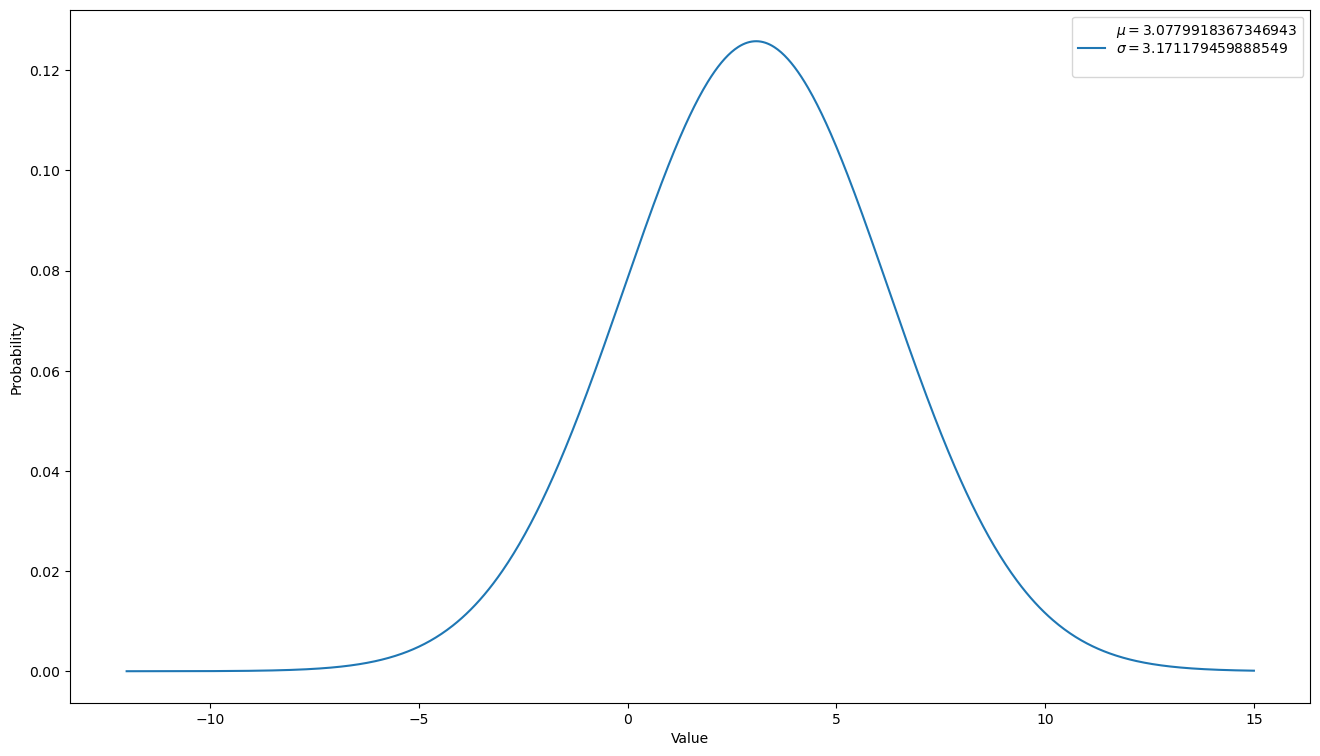

In [521]:
domain = np.linspace(-12, 15, 1000) # dividing the distance between -2 and 2 into 1000 points


means = [np.mean(meanTime)]
std_values = [np.mean(stdTime)]

plt.figure(figsize=(16, 9))
for mu, std in zip(means, std_values):
    # pdf stands for Probability Density Function, which is the plot the probabilities of each range of values
    probabilities = norm.pdf(domain, mu, std)
    plt.plot(domain, probabilities, label=f"$\mu={mu}$\n$\sigma={std}$\n")

plt.legend()
plt.xlabel("Value")
plt.ylabel("Probability")
plt.show()

In [522]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
 
# setting the values of
# mean and S.D.
mean = np.mean(meanTime)
SD = np.mean(stdTime)
 
# value of cdf between one, two
# and three S.D. around the mean
one_sd = norm.cdf(SD, mean, SD) - norm.cdf(-SD, mean, SD)
two_sd = norm.cdf(2 * SD, mean, SD) - norm.cdf(-2 * SD, mean, SD)
three_sd = norm.cdf(3 * SD, mean, SD) - norm.cdf(-3 * SD, mean, SD)
 
# printing the value of fractions
# within each band
print("Fraction of values within one SD =", one_sd)
print("Fraction of values within two SD =", two_sd)
print("Fraction of values within three SD =", three_sd)

Fraction of values within one SD = 0.4873375380905357
Fraction of values within two SD = 0.8468647643941327
Fraction of values within three SD = 0.9787546507030598


In [ ]:
#Response Time
dataResponseTime = [['3', "shortest_shadowed_part_of_path*100", "60"], 
                    ['5', shortest_total_path_shadowed_length,cost2_total_path_shadowed_length], 
                    ['10', shortest_total_path_length, cost2_total_path_length],
                    ['15', "-", 1-shortest_total_path_length/cost2_total_path_length],
                    ['20', "-", 1-shortest_total_path_length/cost2_total_path_length],
                    ['27', "-", 1-shortest_total_path_length/cost2_total_path_length]]
df_columns_resp = ['Distance (km)', 'Response Time (ms)', 'Travelled Nodes (pcs)']
dfStatsOnePath=create_df(data, df_columns_resp)

In [250]:
# Function which makes feature collection from a list
def coords_to_geoJson(listCoord):
    coords = []
    for pt in listCoord:
         coords.append((pt[0], pt[1]))


    my_list = LineString(coords)

    my_feature = Feature(geometry=my_list)

    feature_collection = FeatureCollection([my_feature])
    return feature_collection

In [282]:

regular_shortest_path = nx.shortest_path(G, source=55584, target=54674, weight='full_length')
optimal_path_test1 = nx.shortest_path(G, source=55584, target=54674, weight=weight_function_1)
optimal_path_test2 = nx.shortest_path(G, source=55584, target=54674, weight=weight_function_2)

In [287]:
#coords_to_geoJson(get_path_coords(regular_shortest_path))
#print("Hello1")
coords_to_geoJson(get_path_coords(optimal_path_test2))
# print("Hello2")
#coords_to_geoJson(get_path_coords(regular_shortest_path))
#coords_to_geoJson(get_path_coords(optimal_path_test1))



{"features": [{"geometry": {"coordinates": [[-1.171658, 52.952377], [-1.171469, 52.952479], [-1.171106, 52.952688], [-1.171022, 52.952739], [-1.170876, 52.952827], [-1.170714, 52.952932], [-1.1705, 52.953073], [-1.169981, 52.953418], [-1.169404, 52.953748], [-1.16916, 52.953858], [-1.169009, 52.953925], [-1.168771, 52.954031], [-1.168143, 52.95428], [-1.167332, 52.954545], [-1.167116, 52.954605], [-1.166936, 52.954655], [-1.166614, 52.954737], [-1.166278, 52.954804], [-1.165365, 52.95498], [-1.164152, 52.955225], [-1.163318, 52.955396], [-1.163211, 52.955443], [-1.162988, 52.955621], [-1.163078, 52.955771], [-1.162975, 52.95594], [-1.162926, 52.955968], [-1.162611, 52.956127], [-1.162386, 52.956202], [-1.162247, 52.956201], [-1.161522, 52.955929], [-1.161067, 52.955886], [-1.159919, 52.956271], [-1.159625, 52.956273], [-1.159202, 52.956272], [-1.157796, 52.956084], [-1.156712, 52.956019], [-1.154867, 52.955924], [-1.154659, 52.955913], [-1.152574, 52.955919], [-1.151164, 52.956238], [-

In [288]:
shortest_total_path_length= get_total_path_length(regular_shortest_path)
shortest_shadowed_part_of_path = get_shadowed_part_of_path(regular_shortest_path) 
shortest_total_path_shadowed_length = get_total_path_shadowed_length(regular_shortest_path)

cost1_total_path_length= get_total_path_length(optimal_path_test1)
cost1_shadowed_part_of_path = get_shadowed_part_of_path(optimal_path_test1) 
cost1_total_path_shadowed_length = get_total_path_shadowed_length(optimal_path_test1)

cost2_total_path_length= get_total_path_length(optimal_path_test2)
cost2_shadowed_part_of_path = get_shadowed_part_of_path(optimal_path_test2) 
cost2_total_path_shadowed_length = get_total_path_shadowed_length(optimal_path_test2)

In [472]:
data = [['Shadow part (%)', shortest_shadowed_part_of_path*100, cost2_shadowed_part_of_path*100], 
         ['Shadow length (m)', shortest_total_path_shadowed_length,cost2_total_path_shadowed_length], 
         ['Full length (m)', shortest_total_path_length, cost2_total_path_length],
         ['Ratio (%)', "-", 1-shortest_total_path_length/cost2_total_path_length]]

df_columns = ["One Path", 'Shortest Path', 'Optimal Path']

dfStatsOnePath=create_df(data, df_columns)

In [473]:
dfStatsOnePath

,One Path,Shortest Path,Optimal Path
0,Shadow part (%),21.421075,27.569690
1,Shadow length (m),849.649586,1108.406651
2,Full length (m),3966.418987,4020.381225
3,Ratio (%),-,0.013422
